This is the first working notebook pipeline for the areal challenge solution

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os

from tqdm import tqdm
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error

print("Imported Libraries Successfully")

Imported Libraries Successfully


In [2]:
VERSION = "v2"

In [18]:
# import os

# !ls -lh /kaggle/working

# import shutil

# # Compress your .npy file
# shutil.make_archive('/kaggle/working/signal_v2', 'zip', '/kaggle/working', 'signal_v2.npy')

# from IPython.display import FileLink
# FileLink('/kaggle/input/ariel-data-challenge-2025/train/1024292144/AIRS-CH0_signal_0.parquet')


/kaggle/input/ariel-data-challenge-2025/train/1024292144/AIRS-CH0_signal_0.parquet

In [3]:
%%writefile preprocess.py

import pandas as pd
import numpy as np
import multiprocessing as mp
import itertools
import os
import subprocess
from astropy.stats import sigma_clip
from numpy.polynomial import Polynomial
from tqdm import tqdm
import torch
import torch.nn.functional as F


ROOT = "/kaggle/input/ariel-data-challenge-2025/"
VERSION = "v2"
A_BINNING = 15
F_BINNING = 12*15


device = ("cuda:0" if torch.cuda.is_available() else "cpu")
print("device : ", device)
MODE = os.getenv('PREPROCESS_MODE')


sensor_sizes_dict = {
    "AIRS-CH0": [[11250, 32, 356], [32, 356]],
    "FGS1": [[135000, 32, 32], [32, 32]],
}  # input, mask

cl = 8
cr = 24


def get_gain_offset():
    """
    Get the gain and offset for a given planet and sensor

    Unlike last year's challenge, all planets use the same adc_info.
    We can just hard code it.
    """
    gain = 0.4369
    offset = -1000.0
    return gain, offset



def read_data(planet_id, sensor, mode):
    """
    Read the data for a given planet and sensor
    """
    # get all noise correction frames and signal
    signal = pd.read_parquet(
        f"{ROOT}/{mode}/{planet_id}/{sensor}_signal_0.parquet",
        engine="pyarrow",
    )
    dark_frame = pd.read_parquet(
        f"{ROOT}/{mode}/{planet_id}/{sensor}_calibration_0/dark.parquet",
        engine="pyarrow",
    )
    dead_frame = pd.read_parquet(
        f"{ROOT}/{mode}/{planet_id}/{sensor}_calibration_0/dead.parquet",
        engine="pyarrow",
    )
    linear_corr_frame = pd.read_parquet(
        f"{ROOT}/{mode}/{planet_id}/{sensor}_calibration_0/linear_corr.parquet",
        engine="pyarrow",
    )
    flat_frame = pd.read_parquet(
        f"{ROOT}/{mode}/{planet_id}/{sensor}_calibration_0/flat.parquet",
        engine="pyarrow",
    )

    # reshape to sensor shape and cast to float64
    signal = signal.values.astype(np.float64).reshape(sensor_sizes_dict[sensor][0])[
        :, cl:cr, :
    ]
    dark_frame = dark_frame.values.astype(np.float64).reshape(
        sensor_sizes_dict[sensor][1]
    )[cl:cr, :]
    dead_frame = dead_frame.values.reshape(sensor_sizes_dict[sensor][1])[cl:cr, :]
    flat_frame = flat_frame.values.astype(np.float64).reshape(
        sensor_sizes_dict[sensor][1]
    )[cl:cr, :]

    linear_corr = linear_corr_frame.values.astype(np.float64).reshape(
        [6] + sensor_sizes_dict[sensor][1]
    )[:, cl:cr, :]

    return (
        signal,
        dark_frame,
        dead_frame,
        linear_corr,
        flat_frame,
    )


def ADC_convert(signal, gain, offset):
    """
    Step 1: Analog-to-Digital Conversion (ADC) correction

    The Analog-to-Digital Conversion (adc) is performed by the detector to convert the
    pixel voltage into an integer number. We revert this operation by using the gain
    and offset for the calibration files 'train_adc_info.csv'.
    """

    signal /= gain
    signal += offset
    return signal


def mask_hot_dead(signal, dead, dark):
    """
    Step 2: Mask hot/dead pixel

    The dead pixels map is a map of the pixels that do not respond to light and, thus,
    can't be accounted for any calculation. In all these frames the dead pixels are
    masked using python masked arrays. The bad pixels are thus masked but left
    uncorrected. Some methods can be used to correct bad-pixels but this task,
    if needed, is left to the participants.
    """

    hot = sigma_clip(dark, sigma=5, maxiters=5).mask
    hot = np.tile(hot, (signal.shape[0], 1, 1))
    dead = np.tile(dead, (signal.shape[0], 1, 1))

    signal[dead] = np.nan
    signal[hot] = np.nan
    return signal


def apply_linear_corr(c, signal):
    """
    Step 3: linearity Correction

    The non-linearity of the pixels' response can be explained as capacitive leakage
    on the readout electronics of each pixel during the integration time. The number
    of electrons in the well is proportional to the number of photons that hit the
    pixel, with a quantum efficiency coefficient. However, the response of the pixel
    is not linear with the number of electrons in the well. This effect can be
    described by a polynomial function of the number of electrons actually in the well.
    The data is provided with calibration files linear_corr.parquet that are the
    coefficients of the inverse polynomial function and can be used to correct this
    non-linearity effect.
    Using horner's method to evaluate the polynomial
    """
    assert c.shape[0] == 6  # Ensure the polynomial is of degree 5

    return (
        (((c[5] * signal + c[4]) * signal + c[3]) * signal + c[2]) * signal + c[1]
    ) * signal + c[0]


def clean_dark(signal, dark, dt):
    """
    Step 4: dark current subtraction

    The data provided include calibration for dark current estimation, which can be
    used to pre-process the observations. Dark current represents a constant signal
    that accumulates in each pixel during the integration time, independent of the
    incoming light. To obtain the corrected image, the following conventional approach
    is applied: The data provided include calibration files such as dark frames or
    dead pixels' maps. They can be used to pre-process the observations. The dark frame
    is a map of the detector response to a very short exposure time, to correct for the
    dark current of the detector.

    image - (dark * dt)

    The corrected image is conventionally obtained via the following: where the dark
    current map is first corrected for the dead pixel.
    """

    dark = torch.tile(dark, (signal.shape[0], 1, 1))
    signal -= dark * dt[:, None, None]
    return signal


def get_cds(signal):
    """
    Step 5: Get Correlated Double Sampling (CDS)

    The science frames are alternating between the start of the exposure and the end of
    the exposure. The lecture scheme is a ramp with a double sampling, called
    Correlated Double Sampling (CDS), the detector is read twice, once at the start
    of the exposure and once at the end of the exposure. The final CDS is the
    difference (End of exposure) - (Start of exposure).
    """

    return torch.subtract(signal[1::2, :, :], signal[::2, :, :])


def correct_flat_field(flat, signal):
    """
    Step 6: Flat Field Correction

    The flat field is a map of the detector response to uniform illumination, to
    correct for the pixel-to-pixel variations of the detector, for example the
    different quantum efficiencies of each pixel.
    """

    return signal / flat


def bin_obs(signal, binning):
    """
    Step 5.1: Bin Observations

    The data provided are binned in the time dimension. The binning is performed by
    summing the signal over the time dimension.
    """

    cds_binned = torch.zeros(
        (
            signal.shape[0] // binning,
            signal.shape[1],
            signal.shape[2],
        ),
        device=device,
    )
    for i in range(signal.shape[0] // binning):
        cds_binned[i, :, :] = torch.sum(
            signal[i * binning : (i + 1) * binning, :, :], axis=0
        )
    return cds_binned


def nan_interpolation(tensor):
    # Assume tensor is of shape (batch, height, width)
    nan_mask = torch.isnan(tensor)

    # Replace NaNs with zero temporarily
    tensor_filled = torch.where(
        nan_mask, torch.tensor(0.0, device=tensor.device), tensor
    )

    # Create a binary mask (0 where NaNs were and 1 elsewhere)
    ones = torch.ones_like(tensor, device=tensor.device)
    weight = torch.where(nan_mask, torch.tensor(0.0, device=tensor.device), ones)

    # Perform interpolation by convolving with a kernel
    # using bilinear interpolation
    kernel = torch.ones(1, 1, 1, 3, device=tensor.device, dtype=tensor.dtype)

    # Apply padding to the tensor and weight to prevent boundary issues
    tensor_padded = F.pad(
        tensor_filled.unsqueeze(1), (1, 1, 0, 0), mode="replicate"
    ).squeeze(1)
    weight_padded = F.pad(weight.unsqueeze(1), (1, 1, 0, 0), mode="replicate").squeeze(
        1
    )

    # Convolve the filled tensor and the weight mask
    tensor_conv = F.conv2d(tensor_padded.unsqueeze(1), kernel, stride=1)
    weight_conv = F.conv2d(weight_padded.unsqueeze(1), kernel, stride=1)

    # Compute interpolated values (normalized by weights)
    interpolated_tensor = tensor_conv / weight_conv

    # Apply the interpolated values only to the positions of NaNs
    result = torch.where(nan_mask, interpolated_tensor.squeeze(1), tensor)

    return result



def process_planet(planet_id):
    """
    Process a single planet's data
    """
    axis_info = pd.read_parquet(ROOT + "/axis_info.parquet")
    dt_airs = axis_info["AIRS-CH0-integration_time"].dropna().values

    for sensor in ["AIRS-CH0", "FGS1"]:
        # load all data for this planet and sensor
        signal, dark_frame, dead_frame, linear_corr, flat_frame = read_data(
            planet_id, sensor, mode=MODE
        )
        gain, offset = get_gain_offset()

        # Step 1: ADC correction
        signal = ADC_convert(signal, gain, offset)

        # Step 2: Mask hot/dead pixel
        signal = mask_hot_dead(signal, dead_frame, dark_frame)

        # clip at 0
        signal = torch.tensor(signal.clip(0)).to(device)    
        signal = apply_linear_corr(
            torch.tensor(linear_corr).to(device), signal.clone().detach()
        )

        if sensor == "FGS1":
            dt = torch.ones(len(signal), device=device) * 0.1
        elif sensor == "AIRS-CH0":
            dt = torch.tensor(dt_airs).to(device)

        dt[1::2] += 0.1

        signal = clean_dark(signal, torch.tensor(dark_frame).to(device), dt)

        # Step 5: Get Correlated Double Sampling (CDS)
        signal = get_cds(signal)

        # Step 6: Flat Field Correction

        if sensor == "AIRS-CH0":
            signal = bin_obs(signal, binning=A_BINNING)
        else:
            signal = bin_obs(signal, binning=F_BINNING)

        signal = correct_flat_field(torch.tensor(flat_frame).to(device), signal)

        # Step 7: Interpolate NaNs (twice!)
        signal = nan_interpolation(signal)
        signal = nan_interpolation(signal)

        if sensor == "FGS1":
            signal = torch.nanmean(signal, axis=[1, 2]).cpu().numpy()
        elif sensor == "AIRS-CH0":
            signal = torch.nanmean(signal, axis=1).cpu().numpy()
            
        # save the processed signal
        np.save(
            str(planet_id) + "_" + sensor + f"_signal_{VERSION}.npy",
            signal.astype(np.float64),
        )

if __name__ == "__main__":
    star_info = pd.read_csv(ROOT + f"/{MODE}_star_info.csv", index_col="planet_id")
    planet_ids = [int(x) for x in star_info.index.tolist()]

    # Use up to 4 threads!
    mp.set_start_method('spawn')
    with mp.Pool(processes=4) as pool:
        list(tqdm(pool.imap(process_planet, planet_ids), total=len(planet_ids)))

    
    signal_train = []

    for planet_id in planet_ids:
        f_raw = np.load(f"{planet_id}_FGS1_signal_{VERSION}.npy")
        a_raw = np.load(f"{planet_id}_AIRS-CH0_signal_{VERSION}.npy")

        # flip a_raw
        signal = np.concatenate([f_raw[:, None], a_raw[:, ::-1]], axis=1)
        signal_train.append(signal)

        os.remove("/kaggle/working/" + str(planet_id) + f"_AIRS-CH0_signal_{VERSION}.npy")
        os.remove("/kaggle/working/" + str(planet_id) + f"_FGS1_signal_{VERSION}.npy")

    signal_train = np.array(signal_train)
    np.save(f"signal_{VERSION}.npy", signal_train, allow_pickle=False)

    print("Processing complete!")

Writing preprocess.py


In [11]:
data_path = f"/kaggle/input/signal-v2-1-npy/signal_{VERSION} (1).npy"
os.environ["PREPROCESS_MODE"] = "train"

# Check if preprocessed data already exists
if not os.path.exists(data_path):
    print("Preprocessed data not found. Running preprocessing...")

    # Set environment variable for your script
    os.environ["PREPROCESS_MODE"] = "train"

    # Run the preprocessing script
    !python preprocess.py

    # (Assuming preprocess.py saves 'signal_{VERSION}.npy')
else:
    print("Preprocessed data already exists. Skipping preprocessing.")

Preprocessed data already exists. Skipping preprocessing.


In [5]:
data_train = np.load(f"/kaggle/input/signal-v2-1-npy/signal_{VERSION} (1).npy")
data_train.shape

(1100, 375, 357)

In [6]:
print("check, done")

check, done


In [ ]:
train_adc_info = pd.read_csv('/kaggle/input/ariel-data-challenge-2025/adc_info.csv')
train_star_info = pd.read_csv('/kaggle/input/ariel-data-challenge-2025/train_star_info.csv')

train_labels = pd.read_csv('/kaggle/input/ariel-data-challenge-2025/train.csv',
                           index_col='planet_id')
wavelengths = pd.read_csv('/kaggle/input/ariel-data-challenge-2025/wavelengths.csv')
axis_info = pd.read_parquet('/kaggle/input/ariel-data-challenge-2025/axis_info.parquet')

In [8]:
from scipy.signal import savgol_filter


MODEL_VERSION = "v2"
PRE_BINNED_TIME = 15

ROOT = "/kaggle/input/ariel-data-challenge-2025/"


# find transit zones
def phase_detector(signal_orig, smooth_window=11):
    signal = signal_orig.reshape(-1, 1).mean(-1)
    signal = savgol_filter(signal, smooth_window, 2)  # smooth
    first_derivative = np.gradient(signal)
    second_derivative = savgol_filter(np.gradient(savgol_filter(first_derivative, 41, 2)), 41, 2)

    local_min = (np.diff(np.sign(np.diff(second_derivative))) > 0).nonzero()[0] + 1
    local_max = (np.diff(np.sign(np.diff(second_derivative))) < 0).nonzero()[0] + 1
    
    if len(local_min) >= 2:
        top2_min_indices = local_min[np.argsort(second_derivative[local_min])[:2]]
    else:
        top2_min_indices = local_min
    
    if len(local_max) >= 2:
        top2_max_indices = local_max[np.argsort(second_derivative[local_max])[-2:]]
    else:
        top2_max_indices = local_max
    top2_min_indices.sort()
    top2_max_indices.sort()

    # 4 extrema of the 2nd derivative and 2 of the 1st
    phase1 = top2_min_indices[0]
    phase2 = top2_max_indices[0]
    phase3 = top2_max_indices[1]
    phase4 = top2_min_indices[1]
    phase5 = np.argmin(first_derivative)
    phase6 = np.argmax(first_derivative)

    return phase1, phase2, phase3, phase4, phase5, phase6


def get_breakpoints(x, smooth=19):
    bp1 = np.zeros(x.shape[0], dtype=np.int32)
    bp2 = np.zeros(x.shape[0], dtype=np.int32)
    bp3 = np.zeros(x.shape[0], dtype=np.int32)
    bp4 = np.zeros(x.shape[0], dtype=np.int32)
    bp5 = np.zeros(x.shape[0], dtype=np.int32)
    bp6 = np.zeros(x.shape[0], dtype=np.int32)
    for i in range(x.shape[0]):
        signal = x[i]
        p1, p2, p3, p4, p5, p6 = phase_detector(
            signal, smooth_window=smooth
        )
        bp1[i] = p1
        bp2[i] = p2
        bp3[i] = p3
        bp4[i] = p4
        bp5[i] = p5
        bp6[i] = p6
        
    return [bp1, bp2, bp3, bp4, bp5, bp6]

In [9]:
%%writefile feature_engineering.py
from scipy.signal import savgol_filter
import warnings
from scipy.stats import kurtosis, skew
from scipy.signal import medfilt
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from numpy.polynomial import Polynomial
from scipy.optimize import least_squares, minimize
from sklearn.metrics import mean_squared_error
from scipy.ndimage import median_filter


warnings.simplefilter("ignore")

A_BINNING = 15

# threshold values for identifying outliers
bad_low = 20
bad_up = 354

buf = 15  # for lower1, upper1
buf1 = 10  # for lower, mid1, mid2, upper


def calculate_weights(a, lower, mid1, mid2, upper, lower1, upper1, is_outlier=False):
    """
    Calculating weights for averaging based on SNR
    """
    max_len = a.shape[0] - 1
    if is_outlier:
        return np.ones_like(a[0]) / a.shape[-1]
    else:
        y_combined = np.concatenate([a[:max(lower - buf1, 1), :], a[min(upper + buf1, max_len):, :]], axis=0)
        ratio = y_combined.mean(0) / y_combined.std(0)
        return ratio / ratio.sum()


def calc_for_outliers(a, lower, upper):
    """
    Estimating transit depth for outlier cases
    """
    max_len = len(a) - 1
            
    if lower + buf < upper - buf:
        obs = a[lower + buf : upper - buf].mean()
    else:
        obs = a[lower : upper].mean()

    if lower - buf >= 10 and max_len - upper - buf >= 10:
        unobs = (np.median(a[:max(lower - buf, 1)]) + np.median(a[min(upper + buf, max_len):])) / 2
    elif lower >= max_len - upper:
        unobs = np.median(a[:max(lower - buf, 1)])
    else:
        unobs = np.median(a[min(upper + buf, max_len):])

    arr1 = 1 - (obs / unobs)
    arr2 = 1 - a[(lower + upper) // 2] / unobs

    return arr1, arr2


def calc_err(x_combined, y_combined, degree):
    """
    Calculating the error to obtain the optimal polynomial degree
    """
    max_len = 374 # hardcoded for BINNING=15
    
    poly_guess = np.polyfit(x_combined, y_combined, degree)
    inter = np.polyval(poly_guess, np.arange(max_len + 1))
    err = mean_squared_error(y_combined, inter[x_combined], squared=False)

    # penalizing rmse, high polynomial degree and small number of points in curve fitting.
    return err * degree**(1 - len(x_combined) / max_len)

    
def calc_depth_and_detrend(a, lower, mid1, mid2, upper, lower1, upper1, is_outlier=False, unstable=False, fixed_degree=None):
    """
    Main function for transit depth estimation and detrending
    
    Parameters:
        - a: 1d numpy array of observation points
        - lower, mid1, mid2, upper, lower1, upper1: transit boundary points
        - is_outlier: boolean flag indicating if the data point is an outlier
        - unstable: if True, don't use curve fitting
        - fixed_degree: if not None, use provided degree; otherwise, find optimal degree
    
    Returns:
        - (arr1, arr2): tuple containing the averaged transit depth and the transit depth at mid-transit
    """
    max_len = len(a) - 1
    degree = 3
    
    if is_outlier:
        a /= a.mean()
        arr1, arr2 = calc_for_outliers(a, lower1, upper1)
    else:
        a /= a.mean()

        # region outside the transit
        x_combined = np.concatenate([np.arange(max(lower - buf1, 1)), np.arange(min(upper + buf1, max_len), max_len + 1)], axis=-1)
        y_combined = a[x_combined]
            
        if fixed_degree is None: # find the optimal degre
            best_val = 10**100
            for j in [1, 2, 3, 4, 5]:
                if calc_err(x_combined, y_combined, j) < best_val:
                    best_val = calc_err(x_combined, y_combined, j)
                    degree = j
        else:
            degree = fixed_degree

        obs = a[mid1 : mid2]
        
        if unstable: # no curve fitting
            unobs = y_combined.mean()
        else:
            poly_guess = np.polyfit(x_combined, y_combined, degree)         
            inter = np.polyval(poly_guess, np.arange(max_len + 1))
                
            a /= inter
            inter /= inter
            unobs = inter[mid1 : mid2]

        arr1 = 1 - np.mean(obs / unobs)
        arr2 = 1 - a[(lower1 + upper1) // 2] / unobs.mean()
                

    if np.isnan(arr1):
        arr1 = 0
    if np.isnan(arr2):
        arr2 = 0
        
    return arr1, arr2


def calc_slope(a, lower, mid1, mid2, upper, lower1, upper1, is_outlier=False):
    """
    Calculate transit wall steepness as slope between contact points
    """
    max_len = len(a) - 1
    
    if not (lower < mid1 < mid2 < upper) or is_outlier:
        return 0
    else:
        return ((a[mid1] - a[lower]) / (mid1 - lower) - (a[upper] - a[mid2]) / (upper - mid2)) / 2


def calc_slope_2(a, lower, mid1, mid2, upper, lower1, upper1, is_outlier=False):
    """
    Calculate transit bottom curvature as slope between mid-transit 
    and contact point
    """
    max_len = len(a) - 1
    
    if not (lower < mid1 < mid2 < upper) or is_outlier:
        return 0
    else:
        mid_ind = (mid1 + mid2) // 2
        if not (mid1 < mid_ind < mid2):
            return 0
        return ((a[mid_ind] - a[mid1]) / (mid_ind - mid1) - (a[mid2] - a[mid_ind]) / (mid2 - mid_ind)) / 2


# calcluating slopes for unsimmetric cases
def calc_slope_2_left(a, lower, mid1, mid2, upper, lower1, upper1, is_outlier=False):
    max_len = len(a) - 1
    
    if not (lower < mid1 < mid2 < upper):
        return 0
    else:
        mid_ind = (mid1 + mid2) // 2
        if not (mid1 < mid_ind < mid2):
            return 0
        return (a[mid_ind] - a[mid1]) / (mid_ind - mid1)


def calc_slope_2_right(a, lower, mid1, mid2, upper, lower1, upper1, is_outlier=False):
    max_len = len(a) - 1
    
    if not (lower < mid1 < mid2 < upper):
        return 0
    else:
        mid_ind = (mid1 + mid2) // 2
        if not (mid1 < mid_ind < mid2):
            return 0
        return (a[mid2] - a[mid_ind]) / (mid2 - mid_ind)


# gradient slopes
def calc_curv_left(a, lower, mid1, mid2, upper, lower1, upper1, is_outlier=False):
    if not (lower < mid1 < mid2 < upper) or is_outlier:
        return 0
    else:
        mid_ind = (mid1 + mid2) // 2
        a = savgol_filter(np.gradient(a), 41, 1)
        return (a[mid_ind] - a[mid1]) / (mid_ind - mid1)


def calc_curv_right(a, lower, mid1, mid2, upper, lower1, upper1, is_outlier=False):
    if not (lower < mid1 < mid2 < upper) or is_outlier:
        return 0
    else:
        mid_ind = (mid1 + mid2) // 2
        a = savgol_filter(np.gradient(a), 41, 1)
        return (a[mid2] - a[mid_ind]) / (mid2 - mid_ind)


def calc_perc(a, lower, upper, q, is_outlier=False):
    """
    Calculate the percentile of the transit depth, assumes the input signal is already detrended
    """
    if is_outlier:
        return 0
    return np.quantile(1 - a[lower : upper], q)
    

def feature_engineering(star_info, data):
    """
    Prepares features for training or inference
    
    Parameters:
        - star_info: star metadata DataFrame
        - data: 3d data array (samples, time, frequencies)
    
    Returns:
        tuple of DataFrame and outliers mask
    """
    df = pd.DataFrame()

    cut_inf, cut_sup = 36, 318
    
    signal = np.concatenate(
        [data[:, :, 0][:, :, None], data[:, :, cut_inf:cut_sup]], axis=2
    )
    max_len = signal.shape[1] - 1
        
    lower, mid1, mid2, upper, lower1, upper1 = get_breakpoints(signal[:, :, 1:].mean(-1))
    boundaries = (lower, mid1, mid2, upper, lower1, upper1) 

    # identifying outliers
    outliers = (np.array(lower1) < bad_low) | (np.array(upper1) > bad_up) | (np.array(lower) < bad_low) | (np.array(upper) > bad_up)
    for i in range(signal.shape[0]):
        if not (lower[i] < mid1[i] < mid2[i] < upper[i]):
            outliers[i] = 1
    
    signal_mean_raw = np.zeros(signal.shape[:2])
    for i in tqdm(range(signal_mean_raw.shape[0])): # weighted averaging along frequency dimension
        weights = calculate_weights(signal[i, :, 1:], *(b[i] for b in boundaries), outliers[i])
        signal_mean_raw[i, :] = (signal[i, :, 1:] @ weights.T).T

    signal_mean = savgol_filter(signal_mean_raw, 11, 1)

    # frequency set for precise depth estimation via curve fitting (less robust)
    good_waves = [1, 6, 11, 16, 21, 26, 31, 36, 41, 51, 61, 71, 76, 81, 86, 91, 96, 101, 106, 111, 121, 131, 141, 151, 161, 171, 196, 201, 206]
    for i in tqdm(range(len(signal_mean))):

        # filter very bad cases :) (exclude from training, use larger sigma for prediction)
        df.loc[i, 'very_bad'] = (lower1[i] < bad_low // 2 or upper1[i] > max_len - (max_len - bad_up) // 2)
        if os.environ["PREPROCESS_MODE"] == 'train' and star_info.loc[i, 'planet_id'] in [2486733311, 2554492145]:
            df.loc[i, 'very_bad'] = True


        # averaged and mid-transit depth estimation
        fake_avg, fake_mid = calc_depth_and_detrend(signal_mean[i].copy(), *(b[i] for b in boundaries), outliers[i], unstable=True)
        fake_avg_2, fake_mid_2 = calc_depth_and_detrend(signal_mean[i].copy(), *(b[i] for b in boundaries), outliers[i], fixed_degree=3)
        df.loc[i, 'average_depth'], df.loc[i, 'mid_depth'] = calc_depth_and_detrend(signal_mean[i], *(b[i] for b in boundaries), outliers[i])

        norm_coef = (1 - df.loc[i, 'average_depth']) / (1 - fake_avg)
        norm_coef_mid = (1 - df.loc[i, 'mid_depth']) / (1 - fake_mid)
        norm_coef_2 = (1 - df.loc[i, 'average_depth']) / (1 - fake_avg_2)
                        
        fg1_signal = signal[i, :, 0].copy()
        fg1_signal = savgol_filter(fg1_signal, 11, 1)
        fg1_slope = savgol_filter(signal[i, :, 0].copy(), 41, 2)
        _, _ = calc_depth_and_detrend(fg1_slope, *(b[i] for b in boundaries), outliers[i], fixed_degree=3) # for detrending
        
        df.loc[i, 'fg1_average_depth'], df.loc[i, 'fg1_mid_depth'] = calc_depth_and_detrend(fg1_signal, *(b[i] for b in boundaries), 
                                                                                            outliers[i], 
                                                                                            fixed_degree=3)

        
        # transit depth percentiles
        for q in [0.01, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]:
            df.loc[i, f'q_1_{q}'] = calc_perc(signal_mean[i], mid1[i], mid2[i], q, outliers[i])
            df.loc[i, f'q_2_{q}'] = calc_perc(signal_mean[i], lower[i] - buf1, upper[i] + buf1, q, outliers[i])
            df.loc[i, f'q_3_{q}'] = calc_perc(signal_mean[i], lower[i], upper[i], q, outliers[i]) 
        for q in [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.7, 0.8, 0.9]:
            df.loc[i, f'fg1_q_1_{q}'] = calc_perc(fg1_signal, mid1[i], mid2[i], q, outliers[i])
            df.loc[i, f'fg1_q_2_{q}'] = calc_perc(fg1_signal, lower[i], upper[i], q, outliers[i])
            df.loc[i, f'fg1_q_3_{q}'] = calc_perc(fg1_signal, lower[i] - buf1, upper[i] + buf1, q, outliers[i])

        
        # slope features
        df.loc[i, 'slope'] = calc_slope(signal_mean[i], *(b[i] for b in boundaries), outliers[i])
        df.loc[i, 'slope_2'] = calc_slope_2(signal_mean[i], *(b[i] for b in boundaries), outliers[i])
        df.loc[i, 'slope_2_left'] = calc_slope_2_left(signal_mean[i], *(b[i] for b in boundaries), outliers[i])
        df.loc[i, 'slope_2_right'] = calc_slope_2_right(signal_mean[i], *(b[i] for b in boundaries), outliers[i])
        df.loc[i, 'slope_g'] = max(0, -df.loc[i, 'slope_2'])**0.5
                          
        df.loc[i, 'fg1_slope'] = calc_slope(fg1_slope, *(b[i] for b in boundaries), outliers[i])     
        df.loc[i, 'fg1_slope_2'] = calc_slope_2(fg1_slope, *(b[i] for b in boundaries), outliers[i])      
        df.loc[i, 'fg1_slope_g'] = max(0, -df.loc[i, 'fg1_slope_2'])**0.5
        df.loc[i, 'fg1_curv_left'] = calc_curv_left(fg1_slope, *(b[i] for b in boundaries), outliers[i])
        df.loc[i, 'fg1_curv_right'] = calc_curv_right(fg1_slope, *(b[i] for b in boundaries), outliers[i])

        
        # combinations with slopes
        df.loc[i, 'slope_rel'] = df.loc[i, 'slope_2'] * df.loc[i, 'average_depth']
        df.loc[i, 'fg1_slope_T'] = df.loc[i, 'fg1_slope_2'] * star_info.loc[i, 'Ts'] 
        df.loc[i, 'fg1_slope_rel'] = df.loc[i, 'fg1_slope_2'] * df.loc[i, 'fg1_average_depth']
        df.loc[i, 'fg1_slope_g_rel'] = df.loc[i, 'fg1_slope_g'] * df.loc[i, 'fg1_average_depth']
        
        for q in [0.01, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]:
            df.loc[i, f'slope_q_{q}'] = df.loc[i, 'slope_2'] * df.loc[i, f'q_1_{q}']
            df.loc[i, f'slope_q_{q}_2'] = df.loc[i, 'slope_2'] * df.loc[i, f'q_2_{q}']

        
        # other features
        df.loc[i, 't14'] = upper[i] - lower[i]
        df.loc[i, 't23'] = mid2[i] - mid1[i]
        df.loc[i, 'time'] = (mid1[i] - lower[i]) / (upper[i] - lower[i])        
        df.loc[i, 'P_mul_Rs'] = star_info.loc[i, 'P'] * star_info.loc[i, 'Rs']
        df.loc[i, 'P_div_Rs'] = star_info.loc[i, 'P'] / star_info.loc[i, 'Rs']
        
        step = 5
        max_rel = 0
        min_rel = 1
        meaning = 60 # window size for frequency averagning
        
        for j in range(1, signal.shape[-1] - meaning + 1, step):
            if j <= 80:
                meaning = 20
            elif j <= 180:
                meaning = 30
            else:
                meaning = 60

            cur_mean = signal[i, :, j : min(j + meaning, signal.shape[-1])].mean(-1)

            # median filter
            if not outliers[i]:
                if j >= 180:
                    med_kernel = 31
                else:
                    med_kernel = 21
                cur_mean = median_filter(cur_mean, size=med_kernel, mode="constant")
                           
            cur_mean = savgol_filter(cur_mean, 11, 1)
            
            df.loc[i, f'averaged_{j}_unstable'], df.loc[i, f'mid_{j}_unstable'] = calc_depth_and_detrend(cur_mean.copy(), *(b[i] for b in boundaries), 
                                                                                                            outliers[i],
                                                                                                            unstable=True)  
            if not outliers[i]:
                df.loc[i, f'averaged_{j}_unstable'] = 1 - (1 - df.loc[i, f'averaged_{j}_unstable']) * norm_coef
  
            if j in good_waves:
                df.loc[i, f'averaged_{j}'], df.loc[i, f'mid_{j}'] = calc_depth_and_detrend(cur_mean, *(b[i] for b in boundaries),
                                                                                              outliers[i],
                                                                                              fixed_degree=3)
                if not outliers[i]:
                    df.loc[i, f'averaged_{j}'] = 1 - (1 - df.loc[i, f'averaged_{j}']) * norm_coef_2

            
            # percentiles
            for q in [0.1, 0.15, 0.2]:
                if j in good_waves and not outliers[i]:
                    df.loc[i, f'q_w_{j}_{q}'] = calc_perc(cur_mean, mid1[i], mid2[i], q, outliers[i])
                elif outliers[i] and mid1[i] < mid2[i]:
                    x_combined = np.concatenate([np.arange(max(lower[i] - buf1, 1)), np.arange(min(upper[i] + buf1, max_len), max_len + 1)], axis=-1)
                    mid_q = np.quantile(cur_mean[mid1[i] : mid2[i]], q)
                    df.loc[i, f'q_w_{j}_{q}'] = 1 - mid_q / cur_mean[x_combined].mean()
                else:
                    df.loc[i, f'q_w_{j}_{q}'] = 0
           
            
            max_rel = max(max_rel, df.loc[i, f'averaged_{j}_unstable'])
            min_rel = min(min_rel, df.loc[i, f'averaged_{j}_unstable'])

  
            # slope combinations
            df.loc[i, f'averaged_slope_{j}'] = df.loc[i, f'averaged_{j}_unstable'] * df.loc[i, 'slope_2']
            df.loc[i, f'averaged_slope_g_{j}'] = df.loc[i, f'averaged_{j}_unstable'] * df.loc[i, 'slope_g']

        
        # large amplitude     
        if max_rel - min_rel >= 0.005:
            df.loc[i, 'very_bad'] = True

    
    df['Rs'] = star_info['Rs']
    df['Ms'] = star_info['Ms']
    df['Ts'] = star_info['Ts']
    df['sma'] = star_info['sma']  
    df['g'] = np.log10(star_info['Ms'] / (star_info['Rs']**2))
    df['g_T'] = df['g'] * star_info['Ts']
    df['big_rs'] = (star_info['Rs'] > np.quantile(star_info['Rs'].values, 0.97))
    
    df['outliers'] = outliers

    df = df.fillna(0)
    
    return outliers, df

Writing feature_engineering.py


In [12]:
exec(open('feature_engineering.py', 'r').read())
outliers, train = feature_engineering(train_star_info, data_train)
outliers = np.arange(train.shape[0])[outliers]
len(outliers)

100%|██████████| 1100/1100 [16:21<00:00,  1.12it/s]


61

# R2 score: 0.999
# Root mean squared error: 0.000345


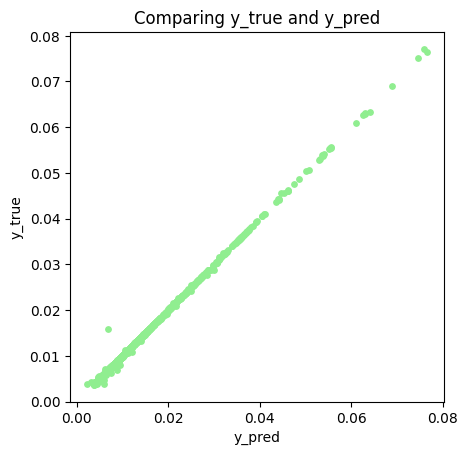

In [26]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, ClassifierMixin, RegressorMixin
from sklearn.utils.validation import check_is_fitted


class CustomRidge(BaseEstimator):
    """
    Provides two models: main model for normal cases and outlier-specific model
    """
    def __init__(self):
        self.main = Ridge(alpha=3e-2) 
        self.outliers = Ridge(alpha=3e-1)

        self.main_scaler = RobustScaler()
        self.outliers_scaler = RobustScaler()


    def fit(self, X, y):
        groups = X['outliers']
        X = X.drop(columns=['outliers'])

        main_mask = (groups == 0).values
        main_mask[X.loc[:, 'very_bad'] == True] = 0
        
        X_main = self.main_scaler.fit_transform(X[main_mask])

        self.main.fit(self.main_scaler.transform(X[main_mask]), y[main_mask])
        self.outliers.fit(self.outliers_scaler.fit_transform(X), y)     
        self.pred_shape = y.shape[-1]

        return self

    def predict(self, X):
        groups = X['outliers']
        X = X.drop(columns=['outliers'])
        
        predictions = np.zeros((X.shape[0], self.pred_shape))

        main_mask = (groups == 0).values
        if main_mask.sum():
            predictions[main_mask] = self.main.predict(self.main_scaler.transform(X[main_mask]))                                                 
        if (~main_mask).sum():
            predictions[~main_mask] = self.outliers.predict(self.outliers_scaler.transform(X[~main_mask]))
        
        return predictions


model = CustomRidge()

oof_pred = cross_val_predict(model, train, train_labels.values, cv=100)

print(f"# R2 score: {r2_score(train_labels, oof_pred):.3f}")

sigma_pred = mean_squared_error(train_labels, oof_pred, squared=False)
  
print(f"# Root mean squared error: {sigma_pred:.6f}")

col = 1
plt.scatter(oof_pred[:,col], train_labels.iloc[:,col], s=15, c='lightgreen')
plt.gca().set_aspect('equal')
plt.xlabel('y_pred')
plt.ylabel('y_true')
plt.title('Comparing y_true and y_pred')
plt.show()

# clipping
oof_pred = np.maximum(oof_pred, 0.003)
oof_pred = np.minimum(oof_pred, 0.1)

In [27]:
class SigmaPredictor:
    """
    Class for sigma predicting
    """
    def __init__(self):
        self.sigmas = {}
        
    def fit(self, y_pred, y_true, outliers, very_bad):        
        outliers = [i for i in outliers if i not in very_bad]

        self.sigmas['outliers'] = self._calc(y_pred[outliers], y_true[outliers]) * 5

        main = self._del_outliers(np.ones(len(y_pred), dtype=bool), outliers + list(very_bad))
        self.sigmas['main'] = self._calc(y_pred[main], y_true[main])

        print({ k: v.mean() for k, v in self.sigmas.items() })

    def predict(self, sigma_pred, y_pred, outliers, very_bad, bootstrap_preds=None):
        if len(outliers) > 0:
            sigma_pred[outliers] = self.sigmas['outliers']

        main = self._del_outliers(np.ones(len(y_pred), dtype=bool), outliers)
        if main.sum() > 0:
            sigma_pred[main] = self.sigmas['main']

        W1 = 0.75
        W2 = 1.0 - W1
        
        sigma_pred[main, :] = bootstrap_preds[main, :] * W1 + sigma_pred[main, :] * W2
        sigma_pred[outliers] = bootstrap_preds[outliers] * 1.5

        sigma_pred[very_bad] = 0.003 
        for i in very_bad:
            if i in outliers:
                continue
            sigma_pred[i, :] = 0.5 * bootstrap_preds[i, :] + 0.5 * sigma_pred[i, :]

        return sigma_pred
        

    def _calc(self, y_pred, y_true): # calculate rmse for each frequency
        sigmas = []
        for i in range(y_pred.shape[1]):
            sigmas.append(mean_squared_error(y_pred[:, i], y_true[:, i], squared=False))
        return np.array(sigmas)

    def _del_outliers(self, mask, outliers):
        for i in range(len(mask)):
            if i in outliers:
                mask[i] = False
        return mask                         


def postprocessing(pred_array, index, sigma_pred, sigma_predictor, outliers, very_bad, bootstrap_preds=None, column_names=None):
    """
    Creates a submission DataFrame with mean predictions and uncertainties.

    Parameters:
    - pred_array: ndarray of shape (n_samples, 283)
    - index: pandas.Index of length n_samples
    - sigma_pred: float or ndarray of shape (n_samples, 283)
    - column_names: list of wavelength column names (optional)

    Returns:
    - df: DataFrame of shape (n_samples, 566)
    """
    n_samples, n_waves = pred_array.shape

    if column_names is None:
        column_names = [f"wl_{i+1}" for i in range(n_waves)]
    
    sigma_pred = sigma_predictor.predict(np.zeros_like(pred_array), pred_array, outliers, very_bad, bootstrap_preds=bootstrap_preds)

    # Safety check
    assert sigma_pred.shape == pred_array.shape, "sigma_pred must match shape of pred_array"
    assert len(index) == n_samples, "Index length must match number of rows"

    df_mean = pd.DataFrame(pred_array.clip(0, None), index=index, columns=column_names)
    df_sigma = pd.DataFrame(sigma_pred, index=index, columns=[f"sigma_{i+1}" for i in range(n_waves)])

    return pd.concat([df_mean, df_sigma], axis=1)

In [28]:
model.fit(train, train_labels)

sigma_predictor = SigmaPredictor()
very_bad = np.arange(train_labels.shape[0])[train['very_bad'].values == True]
sigma_predictor.fit(oof_pred, train_labels.values, outliers, very_bad)

{'outliers': 0.0026830860256072528, 'main': 8.155947694561344e-05}


In [29]:
def bootstrap_uncertainty_inference( 
    X_train,
    y_train,
    X_test,
    n_bootstraps = 100, 
    random_state = 42,
):
    """
    Sigma estimation via bootstrapping
    """
    if random_state is not None:
        np.random.seed(random_state)
    
    y_train_values = y_train
        
    n_test_samples = X_test.shape[0]
    n_targets = y_train_values.shape[1]
    
    predictions = np.full((n_test_samples, n_targets, n_bootstraps), np.nan)
    
    bootstrap_iter = range(n_bootstraps)
    bootstrap_iter = tqdm(bootstrap_iter, desc="bootstrap interations")
    
    for b in bootstrap_iter:
        bootstrap_indices = np.random.choice(
            len(X_train), size=len(X_train), replace=True
        )
        
        X_bootstrap = X_train.iloc[bootstrap_indices].reset_index(drop=True)
        y_bootstrap = y_train_values.iloc[bootstrap_indices].reset_index(drop=True)
        
        model_bootstrap = CustomRidge()
        model_bootstrap.fit(X_bootstrap, y_bootstrap)
        
        y_pred = model_bootstrap.predict(X_test)   
        predictions[:, :, b] = y_pred
     
    return predictions

In [30]:
import pickle
import gc


test_adc_info = pd.read_csv('/kaggle/input/ariel-data-challenge-2025/test_star_info.csv', index_col='planet_id')
sample_submission = pd.read_csv('/kaggle/input/ariel-data-challenge-2025/sample_submission.csv', index_col='planet_id')
wavelengths = pd.read_csv('/kaggle/input/ariel-data-challenge-2025/wavelengths.csv')
test_star_info = pd.read_csv('/kaggle/input/ariel-data-challenge-2025/test_star_info.csv')

del data_train

gc.collect()
os.environ["PREPROCESS_MODE"] = "test"

!python preprocess.py
!rm -rf *AIRS-CH0_signal*

data_test = np.load(f"signal_{VERSION}.npy")

outliers, test_features = feature_engineering(test_star_info, data_test)
outliers = np.arange(test_features.shape[0])[outliers]
very_bad = np.arange(test_features.shape[0])[test_features['very_bad'].values == True]

test_pred = model.predict(test_features)

boot_pred = bootstrap_uncertainty_inference(train, train_labels, test_features, n_bootstraps=1000)
test_bootstrap_preds = boot_pred.std(-1) * 2.75

test_pred = np.maximum(test_pred, 0.003)
test_pred = np.minimum(test_pred, 0.1)

print('sigma', sigma_pred)


def postprocessing(pred_array, index, sigma_pred, sigma_predictor, outliers, very_bad, bootstrap_preds=None, column_names=None):
    """
    Convert predictions and uncertainty into final submission DataFrame
    """

    sigma_array = sigma_predictor.predict(np.zeros_like(pred_array), pred_array, outliers, very_bad, bootstrap_preds=bootstrap_preds)

    df_pred = pd.DataFrame(pred_array.clip(0, None), index=index, columns=column_names)
    df_sigma = pd.DataFrame(sigma_array, index=index, columns=[f"sigma_{i}" for i in range(1, len(column_names)+1)])
    return pd.concat([df_pred, df_sigma], axis=1)


submission_df = postprocessing(
    pred_array=test_pred,
    index=sample_submission.index,
    sigma_pred=sigma_pred,
    sigma_predictor=sigma_predictor,
    column_names=wavelengths.columns,
    bootstrap_preds=test_bootstrap_preds,
    outliers=outliers,
    very_bad=very_bad
)

submission_df.to_csv('submission.csv')
!head submission.csv

device :  cuda:0
  0%|                                                     | 0/1 [00:00<?, ?it/s]device :  cuda:0
device :  cuda:0
device :  cuda:0
device :  cuda:0
100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.95s/it]
Processing complete!


bootstrap interations: 100%|██████████| 1000/1000 [07:06<00:00,  2.35it/s]

sigma 0.0003446284042227292
planet_id,wl_1,wl_2,wl_3,wl_4,wl_5,wl_6,wl_7,wl_8,wl_9,wl_10,wl_11,wl_12,wl_13,wl_14,wl_15,wl_16,wl_17,wl_18,wl_19,wl_20,wl_21,wl_22,wl_23,wl_24,wl_25,wl_26,wl_27,wl_28,wl_29,wl_30,wl_31,wl_32,wl_33,wl_34,wl_35,wl_36,wl_37,wl_38,wl_39,wl_40,wl_41,wl_42,wl_43,wl_44,wl_45,wl_46,wl_47,wl_48,wl_49,wl_50,wl_51,wl_52,wl_53,wl_54,wl_55,wl_56,wl_57,wl_58,wl_59,wl_60,wl_61,wl_62,wl_63,wl_64,wl_65,wl_66,wl_67,wl_68,wl_69,wl_70,wl_71,wl_72,wl_73,wl_74,wl_75,wl_76,wl_77,wl_78,wl_79,wl_80,wl_81,wl_82,wl_83,wl_84,wl_85,wl_86,wl_87,wl_88,wl_89,wl_90,wl_91,wl_92,wl_93,wl_94,wl_95,wl_96,wl_97,wl_98,wl_99,wl_100,wl_101,wl_102,wl_103,wl_104,wl_105,wl_106,wl_107,wl_108,wl_109,wl_110,wl_111,wl_112,wl_113,wl_114,wl_115,wl_116,wl_117,wl_118,wl_119,wl_120,wl_121,wl_122,wl_123,wl_124,wl_125,wl_126,wl_127,wl_128,wl_129,wl_130,wl_131,wl_132,wl_133,wl_134,wl_135,wl_136,wl_137,wl_138,wl_139,wl_140,wl_141,wl_142,wl_143,wl_144,wl_145,wl_146,wl_147,wl_148,wl_149,wl_150,wl_151,wl_152,wl_153

# 

In [32]:
import joblib
import os

# after training
os.makedirs("/kaggle/working/models", exist_ok=True)
joblib.dump(model, "/kaggle/working/models/custom_ridge.pkl")

print("✅ Model saved at /kaggle/working/models/custom_ridge.pkl")


os.makedirs("/kaggle/working/models", exist_ok=True)
joblib.dump(sigma_predictor, "/kaggle/working/models/SigmaPredictor.pkl")

print("✅ sigma_predictor saved at /kaggle/working/models/SigmaPredictor.pkl")

✅ Model saved at /kaggle/working/models/custom_ridge.pkl
✅ Model saved at /kaggle/working/models/SigmaPredictor.pkl
